In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
plt.rcParams['figure.figsize'] = [6,6]
sns.set_theme(style="darkgrid")
%matplotlib inline

import nltk
from nltk import sent_tokenize
from nltk.corpus import stopwords
stopwords = nltk.corpus.stopwords.words('english')
from nltk.tokenize import word_tokenize

import contractions
import re
import itertools
import datetime
import time
from collections import Counter
import string

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Embedding
from keras.layers import Flatten

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import GridSearchCV

Thisis a dataset of 72,134 news articles with 35,028 real and 37,106 fake news. For this, authors merged four popular news datasets (i.e. Kaggle, McIntire, Reuters, BuzzFeed Political) to prevent over-fitting of classifiers and to provide more text data for better ML training.

Dataset contains four columns: Serial number (starting from 0); Title (about the text news heading); Text (about the news content); and Label (0 = fake and 1 = real).

There are 78098 data entries in csv file out of which only 72134 entries are accessed as per the data frame

In [2]:
#Loading the Dataset
df = pd.read_csv("WELFake_Dataset.csv")
df

,Unnamed: 0,title,text,label
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,1,NaN,Did they post their votes for Hillary already?,1
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1
...,...,...,...,...
72129,72129,Russians steal research on Trump in hack of U....,WASHINGTON (Reuters) - Hackers believed to be ...,0
72130,72130,WATCH: Giuliani Demands That Democrats Apolog...,"You know, because in fantasyland Republicans n...",1
72131,72131,Migrants Refuse To Leave Train At Refugee Camp...,Migrants Refuse To Leave Train At Refugee Camp...,0
72132,72132,Trump tussle gives unpopular Mexican leader mu...,MEXICO CITY (Reuters) - Donald Trump’s combati...,0


In [3]:
#checking shape of Dataset
df.shape

(72134, 4)

In [4]:
#checking for Null values
df.isna().sum()

Unnamed: 0      0
title         558
text           39
label           0
dtype: int64

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72134 entries, 0 to 72133
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  72134 non-null  int64 
 1   title       71576 non-null  object
 2   text        72095 non-null  object
 3   label       72134 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 2.2+ MB


In [6]:
#droping the Unnamed: 0 column
df.drop("Unnamed: 0",axis=1,inplace=True)

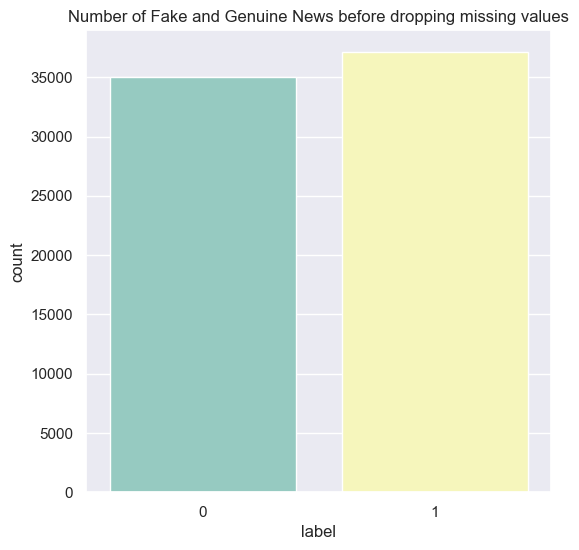

In [7]:
#ploting the count of Fake and Genuine news
sns.countplot(x='label', data=df, palette='Set3')
plt.title("Number of Fake and Genuine News before dropping missing values")
plt.show()

In [8]:
#droping Null values
df.dropna(axis=0, how='any',inplace=True)

In [9]:
#checking Null values
df.isna().sum()

title    0
text     0
label    0
dtype: int64

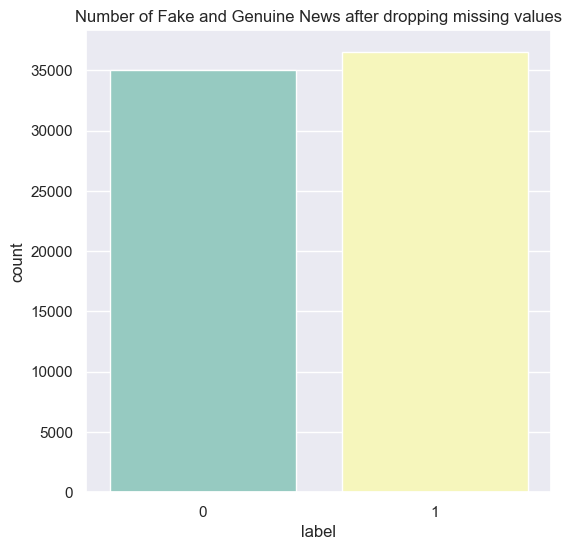

In [10]:
#ploting the count of Fake and Genuine news
sns.countplot(x='label', data=df, palette='Set3')
plt.title("Number of Fake and Genuine News after dropping missing values")
plt.show()

In [11]:
#creating new column with length of text
df['raw_text_length'] = df['text'].apply(lambda x: len(x))

In [12]:
df.head()

,title,text,label,raw_text_length
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1,5049
2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1,216
3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0,8010
4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1,1916
5,About Time! Christian Group Sues Amazon and SP...,All we can say on this one is it s about time ...,1,1530


In [13]:
df.describe()

,label,raw_text_length
count,71537.000000,71537.000000
mean,0.510351,3292.722116
std,0.499896,3738.194002
min,0.000000,1.000000
25%,0.000000,1410.000000
50%,1.000000,2440.000000
75%,1.000000,4077.000000
max,1.000000,142961.000000


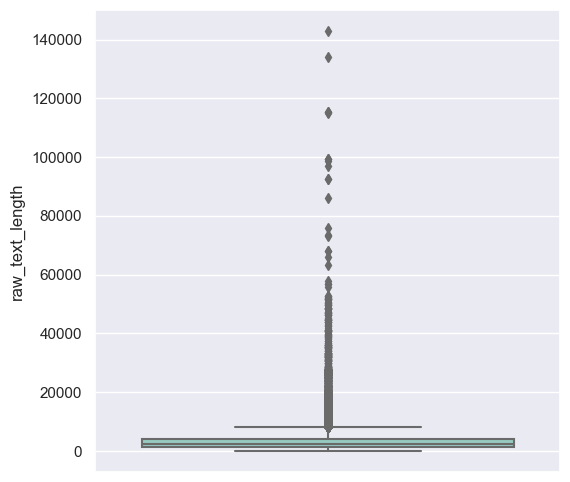

In [14]:
#checking for outliers
sns.boxplot(y='raw_text_length', data=df, palette="Set3")
plt.show()

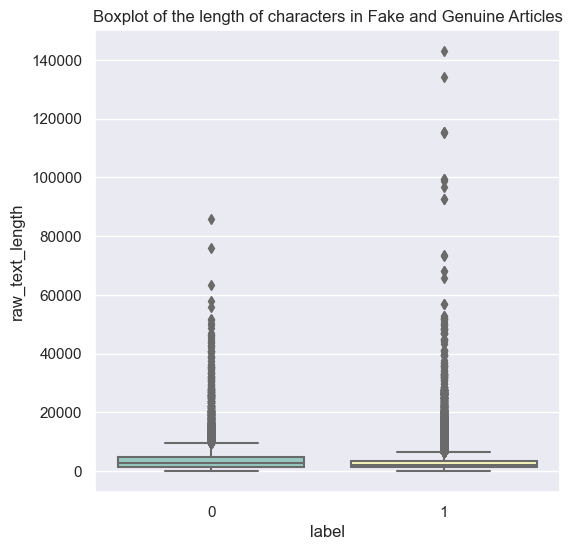

In [15]:
#checking for outliers wit respect to label
sns.boxplot(y='raw_text_length', x='label', data=df, palette="Set3")
plt.title("Boxplot of the length of characters in Fake and Genuine Articles")
plt.show()

In [16]:
df['raw_text_length'].describe()

count     71537.000000
mean       3292.722116
std        3738.194002
min           1.000000
25%        1410.000000
50%        2440.000000
75%        4077.000000
max      142961.000000
Name: raw_text_length, dtype: float64

In [17]:
df[df['raw_text_length']==1]

,title,text,label,raw_text_length
7,HOUSE INTEL CHAIR On Trump-Russia Fake Story: ...,,1,1
106,MARKETWATCH LEFTIST: MSM’s “Blatant” Anti Trum...,,1,1
325,Ohio State University Student Says Terrorist A...,,1,1
364,JULIAN ASSANGE REVEALS John Podesta’s Hilariou...,,1,1
512,OBAMA’S LIST OF 21 MEDAL OF FREEDOM Recipients...,,1,1
...,...,...,...,...
71771,WOW! JILL STEIN’S ‘FIRESIDE CHAT’ Exposes Her ...,,1,1
71914,WATCH TUCKER CARLSON Scorch Sanctuary City May...,,1,1
72026,BOOM! Woman Tries To Steal TRUMP Signs BUT Thi...,,1,1
72119,BILL O’REILLY Destroys Liberal Pundit On Trump...,,1,1


In [18]:
df['text'] = df['text'].str.strip()

In [19]:
df['raw_text_length'] = df['text'].apply(lambda x: len(x))

In [20]:
len(df[df['raw_text_length']==0])

744

In [21]:
df = df[(df['raw_text_length'] > 500) & (df["raw_text_length"] < 5000)]
df.shape

(52440, 4)

In [22]:
df['raw_text_length'].describe()

count    52440.000000
mean      2363.217220
std       1125.758262
min        501.000000
25%       1515.000000
50%       2260.000000
75%       3088.000000
max       4999.000000
Name: raw_text_length, dtype: float64

In [23]:
df.head()

,title,text,label,raw_text_length
4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1,1916
5,About Time! Christian Group Sues Amazon and SP...,All we can say on this one is it s about time ...,1,1530
8,Sports Bar Owner Bans NFL Games…Will Show Only...,"The owner of the Ringling Bar, located south o...",1,1439
9,Latest Pipeline Leak Underscores Dangers Of Da...,"FILE – In this Sept. 15, 2005 file photo, the ...",1,3007
10,GOP Senator Just Smacked Down The Most Puncha...,The most punchable Alt-Right Nazi on the inter...,1,4679


In [24]:
df.describe(include='all')

,title,text,label,raw_text_length
count,52440,52440,52440.000000,52440.000000
unique,45918,46232,NaN,NaN
top,Highlights: The Trump presidency on April 13 a...,Leave a Reply Click here to get more info on f...,NaN,NaN
freq,8,38,NaN,NaN
mean,NaN,NaN,0.532971,2363.217220
std,NaN,NaN,0.498916,1125.758262
min,NaN,NaN,0.000000,501.000000
25%,NaN,NaN,0.000000,1515.000000
50%,NaN,NaN,1.000000,2260.000000
75%,NaN,NaN,1.000000,3088.000000


## Text Cleaning

1. Remove special characters
2. Expand contractions
3. Convert to lower-case
4. Word Tokenize
5. Remove Stopwords

In [25]:
def preprocess_text(x):
    cleaned_text = re.sub(r'[^a-zA-Z\d\s\']+', '', x)
    word_list = []
    for each_word in cleaned_text.split(' '):
        try:
            word_list.append(contractions.fix(each_word).lower())
        except:
            print(x)
    return " ".join(word_list)

In [26]:
text_cols = ['title' , 'text']

In [ ]:
for col in text_cols:
    print("Processing column: {}".format(col))
    df[col] = df[col].apply(lambda x: preprocess_text(x))

Processing column: title
Processing column: text


In [ ]:
for col in text_cols:
    print("Processing column: {}".format(col))
    df[col] = df[col].apply(word_tokenize)

In [ ]:
for col in text_cols:
    print("Processing column: {}".format(col))
    df[col] = df[col].apply(
        lambda x: [each_word for each_word in x if each_word not in stopwords])

In [ ]:
df.head()

In [ ]:
# since count vectorizer expects strings

df['text_joined'] = df['text'].apply(lambda x: " ".join(x))

In [ ]:
df.head()

In [ ]:
# iterate through the csv file
all_texts_gen = " ".join(df[df['label']==1]['text_joined'])
all_texts_fake = " ".join(df[df['label']==0]['text_joined'])

In [ ]:
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(all_texts_gen)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.title("Genuine News")
plt.show()

In [ ]:
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(all_texts_fake)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.title("Fake News")
plt.show()

In [ ]:
count_vectorizer = CountVectorizer(max_features=300,ngram_range=(1, 2))
tf_idf_transformer = TfidfTransformer(smooth_idf=False)

# fit train data to count vectorizer
count_vectorizer.fit(df['text_joined'].values)
count_vect_train = count_vectorizer.transform(df['text_joined'].values)

# fit ngrams count to tfidf transformers
tf_idf_transformer.fit(count_vect_train)
tf_idf_train = tf_idf_transformer.transform(count_vect_train)

In [ ]:
target = df["label"].values
X_train, X_test, y_train, y_test = train_test_split(tf_idf_train, target , random_state=0)

In [ ]:
df_perf_metrics = pd.DataFrame(columns=['Model', 'Accuracy_Training_Set', 'Accuracy_Test_Set', 'Precision', 'Recall', 'f1_score'])

In [ ]:
df_perf_metrics = pd.DataFrame(columns=[
    'Model', 'Accuracy_Training_Set', 'Accuracy_Test_Set', 'Precision',
    'Recall', 'f1_score', 'Training Time (secs'
])
models_trained_list = []


def get_perf_metrics(model, i):
    # model name
    model_name = type(model).__name__
    # time keeping
    start_time = time.time()
    print("Training {} model...".format(model_name))
    # Fitting of model
    model.fit(X_train, y_train)
    print("Completed {} model training.".format(model_name))
    elapsed_time = time.time() - start_time
    # Time Elapsed
    print("Time elapsed: {:.2f} s.".format(elapsed_time))
    # Predictions
    y_pred = model.predict(X_test)
    # Add to ith row of dataframe - metrics
    df_perf_metrics.loc[i] = [
        model_name,
        model.score(X_train, y_train),
        model.score(X_test, y_test),
        precision_score(y_test, y_pred),
        recall_score(y_test, y_pred),
        f1_score(y_test, y_pred), "{:.2f}".format(elapsed_time)
    ]
    # keep a track of trained models
    models_trained_list.append(model)
    print("Completed {} model's performance assessment.".format(model_name))

In [ ]:
models_list = [LogisticRegression(),
               MultinomialNB(),
               RandomForestClassifier(),
               DecisionTreeClassifier(),
               GradientBoostingClassifier(),
               AdaBoostClassifier()]

In [ ]:
for n, model in enumerate(models_list):
    get_perf_metrics(model, n)

In [ ]:
df_perf_metrics

In [ ]:
RF = RandomForestClassifier(random_state=121)
RF.fit(X_train,y_train)

In [ ]:
def output_lable(n):
    if n == 0:
        return "Fake News"
    elif n == 1:
        return "Not A Fake News"


def manual_testing(news):
    testing_news = {"text": [news]}
    new_def_test = pd.DataFrame(testing_news)
    new_def_test["text"] = new_def_test["text"].apply(preprocess_text)
    new_x_test = new_def_test["text"]
    new_xv_test = count_vectorizer.fit_transform(new_x_test)
    new_xvw_test = tf_idf_transformer.fit_transform(new_xv_test)
    pred_LR = RF.predict(new_xvw_test)

    return print("\n\nLR Prediction: ",output_lable(pred_LR[0]))

In [ ]:
news = str(input())
manual_testing(news)

In [ ]:
news = str(input())
manual_testing(news)

In [ ]:
testing_news = {"text": [news]}
new_def_test = pd.DataFrame(testing_news)
new_def_test["text"] = new_def_test["text"].apply(preprocess_text)
new_x_test = new_def_test["text"]
new_xv_test = count_vectorizer.fit_transform(new_x_test)
pred_LR = RF.predict(new_xv_test)

In [ ]:
RF.predict([])

In [ ]:
df.text_joined[8]